## Introduction

 Using https://www.kaggle.com/brllrb/uber-and-lyft-dataset-boston-ma to gain inside and find patterns.

## Insights from eyeballing the dataset
 
The structed table data is gathered from a sample of both Uber and Lyft rides in Boston MA from Nov 26, 2018 to Dec 18, 2018. There are 57 features total which consists of numerical features such as price of the ride - int, nominal like the id of the example - string, ordinal like the short summary - string, and binary for the ride (only 2 categories - lyft or uber) - string. Some other types of values for the feautres are floats and dates. There are 693071 examples in the dataset, with some of the examples having NA for price.


### Data Wrangling
First I will need to store the dataset in a variable called rideshare. Then after looking over the data, I will delete any example that has an unknown price as that will not be useful for the analysis. Then I will drop the timezone feature because all examples are in New York time as all rides are from Boston and none of the rides left that time zone. So timezone will not contribute to anaylizing the influence of prices and can be deleted to make the dataset cleaner.


In [254]:

import pandas as pd
from matplotlib import pyplot as plt #might use panda/matplot later on

#first thing is to get the data.
rideshare = pd.read_csv("./utility/data/rideshare_kaggle.csv")

#getting ride of null values 
rideshare = rideshare[rideshare['price'].notnull()]

#deleting timezone
rideshare = rideshare.drop('timezone', axis=1)


### Cleaning data
I will be looking at different relationships between variables and price as price is a major factor in the use of ubers and lyfts. To do so I will create a heatmap of variables that are likely to impact price based on what uber and lyft claims factor into price. One note: demand patterns is not a variable in this dataset, therefore I will be using given variables such as temperature that I think will impact the demand patterns. 

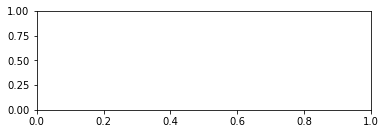

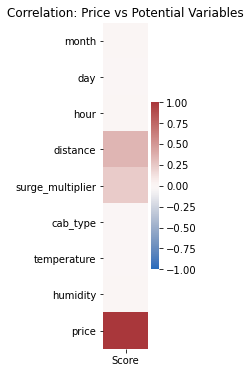

Text(0.5, 1.0, 'Scatterplot Price vs Distance')

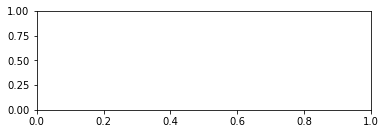

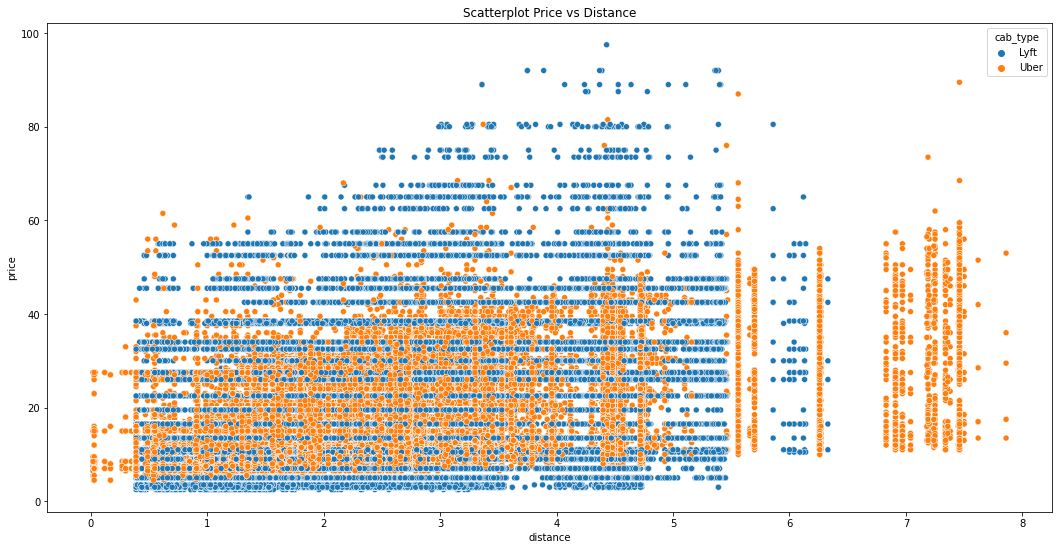

In [255]:

import seaborn as sns
import numpy as np

plt.subplot(211)
t = ["month","day","hour","distance","surge_multiplier","cab_type","temperature","humidity","windSpeed","price"]
ride = rideshare[t]
m = ride.corr()['price']
m = np.array(m)
plt.figure(figsize=(1,6))
sns.heatmap(m[:, None], cmap=sns.cm.vlag, vmin=-1)
plt.xticks([0.5], ['Score'], rotation=0)
plt.yticks(np.arange(m.shape[0]) + 0.5, ["month","day","hour","distance","surge_multiplier","cab_type","temperature","humidity","price"], rotation=0)
plt.title('Correlation: Price vs Potential Variables')
plt.show()

plt.subplot(212)
i = ["price","distance","cab_type"]
r = rideshare[i]
plt.figure(figsize=(18,9))
sns.scatterplot(data = r, x = "distance",
                y = "price", hue = "cab_type")
plt.title("Scatterplot Price vs Distance")




## Analysis and Hypothesis
 While exploring the data set, I became interested in comparing the influence of distance of a ride on price for Lyft and Uber rides(Question). If it is known that one service has a steeper correlation between price and distance that could skrew users to consider the other company, when they need a ride for long distances. Through examining the heatmaps between price and potential factors, I found that distance had one of the strongest correlations to price. Furthermore I plotted a scatter plot which seperated Lyft and Uber rides. Through investigating the data, I believe that Lyft prices increase at a more drastic rate when the distance of a ride increases then Uber(Hypothesus).

## Exploring hypothesis
In order to evaluate the hypothesis, I will need to remove any factors other than distance and cab_type that may influence the price. The dataset has the feature called name which explains the type of ride(uberX, uberXL, shared). In order to compare lyft and uber fairly I will only use 'UberX' and 'Lyft' because both offer the same features as far as type of car and number of passengers goes, and are expected to be around the same price. Another factor in price is the surge multipler so I will use data when the surge multiplier of 1(which means there is no mulitpler). 

In [256]:
lyftUberX = rideshare.loc[(rideshare['name'] == 'Lyft') | (rideshare['name'] == 'UberX') ]
updatedRideshare = lyftUberX.loc[(lyftUberX['surge_multiplier'] == 1)]

importantFeatures = ['distance', 'price', 'cab_type','name']

updatedRideshare[importantFeatures]

,distance,price,cab_type,name
2,0.44,7.0,Lyft,Lyft
11,1.08,7.0,Lyft,Lyft
14,1.11,7.5,Uber,UberX
21,0.72,7.0,Lyft,Lyft
28,2.48,8.5,Uber,UberX
...,...,...,...,...
693039,1.81,9.0,Lyft,Lyft
693051,3.11,10.5,Lyft,Lyft
693052,0.91,7.0,Uber,UberX
693061,1.61,15.0,Uber,UberX


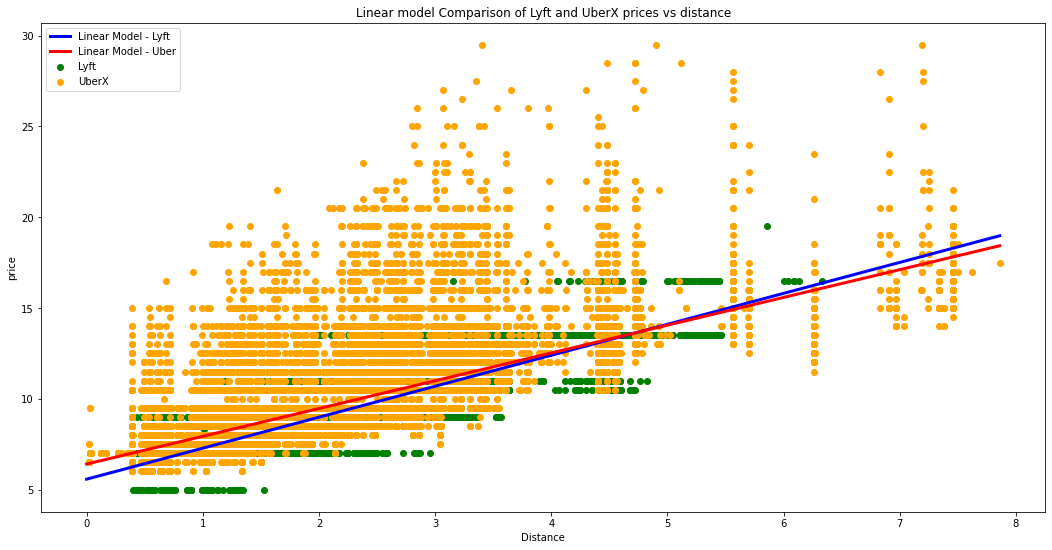

In [257]:

#linear regression 
lyft = updatedRideshare.loc[(updatedRideshare['cab_type'] == 'Lyft')]
X_lyft = lyft[importantFeatures]
y_lyft = lyft['price']

uber = updatedRideshare.loc[(updatedRideshare['cab_type'] == 'Uber') & (updatedRideshare['price'] < 30)]
X_uber = uber[importantFeatures]

y_uber = uber['price']

#turn cab_type to an int


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

XL_train, XL_test, yL_train, yL_test = train_test_split(X_lyft, y_lyft, test_size=0.2, random_state=3)
XU_train, XU_test, yU_train, yU_test = train_test_split(X_uber, y_uber, test_size=0.2, random_state=3)


XL_train_target = XL_train['distance'].values.reshape(-1, 1)

XU_train_target = XU_train['distance'].values.reshape(-1, 1)


                
model = LinearRegression()

model.fit(XL_train_target, yL_train)

xL_star = np.linspace(0, XU_train_target.max(), 1000).reshape(-1,1)


yL_star = model.predict(xL_star)


model = LinearRegression()
model.fit(XU_train_target, yU_train)

xU_star = np.linspace(0, XU_train_target.max(), 1000).reshape(-1,1)


yU_star = model.predict(xU_star)


plt.figure(figsize=(18,9))
plt.scatter(XL_train_target, yL_train, label='Lyft', color="green")
plt.plot(xL_star, yL_star, color="blue", label='Linear Model - Lyft', linewidth = 3)

plt.scatter(XU_train_target, yU_train, label='UberX' , color = 'orange')
plt.plot(xU_star, yU_star, color="red", label='Linear Model - Uber', linewidth = 3)

plt.ylabel("price")
plt.xlabel("Distance")
plt.title("Linear model Comparison of Lyft and UberX prices vs distance")
plt.legend()
plt.show()

## Conclusion
Through the use of linear regression to generate predictions for what the price would be for Uberx and lyft rides based on distance, I found that lyft prices are not predicted to be the same as uber prices. Looking at the graph, before around 4.8 miles Lyft rides are expected to be cheaper than uber, however after 4.8 miles uber becomes more expensive than lyft. This analysis supports the claim made in the hypothesis and further gives information about the relationship between lyft and uber prices on shorter rides. 

## Additional points
One thing worthnoting is that this dataset is from Boston MA from Nov 26, 2018 to Dec 18, 2018. Therefore it is slightly outdated and from a specific region. The results from the hypothesis may not be expected today and in a different city. This is important because the stakeholders in this analysis are users of uber and lyft who are more concious of prices. If they were to follow the hypothesis and choose lyft for a short ride, there's no garentie that the price will be cheaper because of the outdated and regional dataset. Therefore they will be paying mroe than needed for a ride because they chose to trust the analysis instead of checking the prices for both lyft and uber. In order to make such a broad claim about the differences in prices for uber and lyft based on distance, more sample data will be needed from different regions to better reflect everyone in the US. 